<a href="https://colab.research.google.com/github/jess-spayd/wwcode-daysofcodechallenge-2024/blob/main/deep-learning/week01/week01_bonus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

!pip install -Uqq fastai duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 13.3 MB/s eta 0:00:00


In [3]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    with DDGS() as ddgs:
        ddgs_images_gen = ddgs.images(
            keywords=term,
            max_results=max_images
        )
        return L(ddgs_images_gen).itemgot('image')

In [4]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('succulent photos', max_images=1)
urls[0]

Searching for 'succulent photos'


'https://images.pexels.com/photos/1373896/pexels-photo-1373896.jpeg?cs=srgb&dl=succulent-plant-1373896.jpg&fm=jpg'

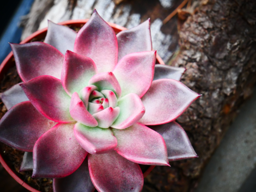

In [5]:
from fastdownload import download_url
dest = 'succulent.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'sunflower photos'


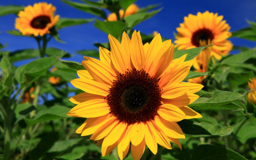

In [28]:
download_url(search_images('sunflower photos', max_images=1)[0], 'sunflower.jpg', show_progress=False)
Image.open('sunflower.jpg').to_thumb(256,256)

In [29]:
searches = 'succulent','sunflower'
path = Path('succulent_or_sunflower')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'succulent photo'
Searching for 'succulent sun photo'
Searching for 'succulent shade photo'
Searching for 'sunflower photo'
Searching for 'sunflower sun photo'
Searching for 'sunflower shade photo'


In [30]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

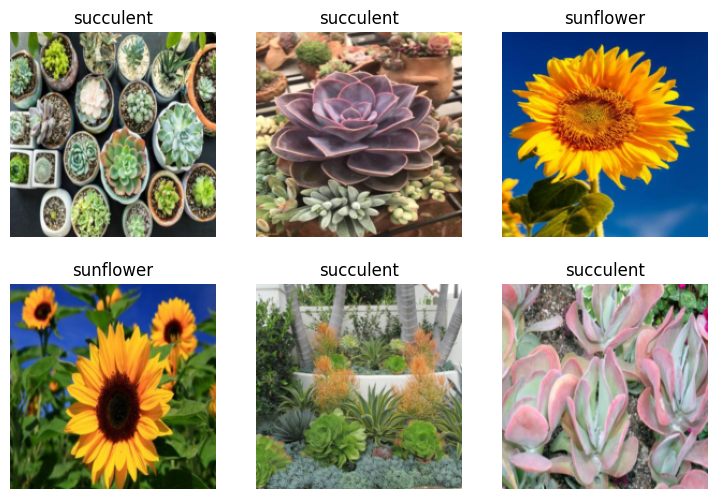

In [31]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [32]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.839890,0.147952,0.062500,00:20


epoch,train_loss,valid_loss,error_rate,time
0,0.177800,0.047713,0.000000,00:28
1,0.103418,0.012077,0.000000,00:29
2,0.071516,0.009078,0.000000,00:28


In [33]:
is_succulent,_,probs = learn.predict(PILImage.create('succulent.jpg'))
print(f"This is a: {is_succulent}.")
print(f"Probability it's a succulent: {probs[0]:.4f}")

This is a: succulent.
Probability it's a succulent: 1.0000


In [34]:
is_succulent,_,probs = learn.predict(PILImage.create('sunflower.jpg'))
print(f"This is a: {is_succulent}.")
print(f"Probability it's a succulent: {probs[0]:.4f}")

This is a: sunflower.
Probability it's a succulent: 0.0000
